In [1]:
# import the necessary packages
from keras.models import Sequential
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv3D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
BIG = 15
def build(n, width, height, depth, reg, init="he_normal"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (n, height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    #if K.image_data_format() == "channels_first":
    #    inputShape = (depth, height, width)
    #    chanDim = 1
        
    # our first CONV layer will learn a total of 16 filters, each
    # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
    # the spatial dimensions of the volume
    model.add(Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding="same",
        kernel_initializer=init, kernel_regularizer=reg,
        input_shape=inputShape))

    # here we stack two CONV layers on top of each other where
    # each layerswill learn a total of 32 (3x3) filters
    model.add(Conv3D(32, (3, 3, 3), padding="same",
        kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding="same",
        kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dropout(0.25))
    # stack two more CONV layers, keeping the size of each filter
    # as 3x3 but increasing to 64 total learned filters
    #model.add(Conv3D(64, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Conv3D(64, (3, 3), strides=(1, 1), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Dropout(0.25))
#
    ## increase the number of filters again, this time to 128
    #model.add(Conv3D(128, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    model.add(Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding="same",
        kernel_initializer=init, kernel_regularizer=reg))
    model.add(Conv3D(1, (3, 3, 3), strides=(1, 1, 1), padding="same",
        kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Flatten())
    #model.add(Dense(100))
    #model.add(Dense(10))
    #model.add(Dense(1))
    #model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    return model

In [3]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
#matplotlib.use("Agg")
 
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
from joblib import load, dump
import numpy as np
import argparse
import cv2
import os

In [4]:
x_axis = slice(35, 120)
y_axis = slice(35, 120)

In [5]:
def normalize(x):
    mean = x.mean()
    std = x.std()
    x = (x-mean)/(std)
    return x - x.min()

def min_max_scalekk(x):
    mn = x.min()
    mx = x.max()
    return (x-mn)/(mx-mn)


In [6]:
high_transformed = normalize(load('files/high_transformed.np')[10:-10, x_axis, y_axis])
low_transformed = normalize(
    normalize((load('files/to_use_in_ml.np'))[10:-10, x_axis, y_axis]) + high_transformed)

In [7]:
high_transformed = np.log(high_transformed+.1)
low_transformed = np.log(low_transformed+.1)

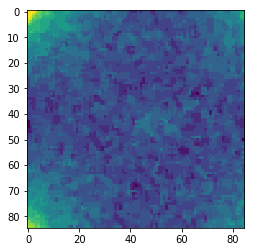

In [8]:
high_transformed.shape
plt.imshow(cv2.medianBlur((min_max_scalekk(high_transformed[90])*255).astype('uint8'), 3))

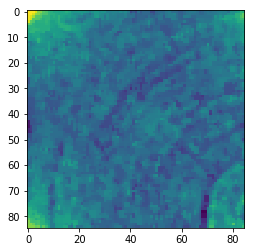

In [9]:
plt.imshow(low_transformed[90])
plt.imshow(cv2.medianBlur((min_max_scalekk(low_transformed[90])*255).astype('uint8'), 3))

In [10]:
plt.imshow(low_transformed[100, :,:,0])
plt.show()
plt.imshow(high_transformed[100,:,:,0])

IndexError: too many indices for array

In [11]:
low_transformed = low_transformed.reshape(1, *low_transformed.shape, 1)
high_transformed = high_transformed.reshape(1, *high_transformed.shape, 1)

In [12]:
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#high_transformed = MinMaxScaler().fit_transform(high_transformed.reshape(-1, 1)).reshape(*high_transformed.shape)
#high_transformed = (high_transformed-high_transformed.mean())/high_transformed.std()

In [13]:
(trainX, testX, trainY, testY) = train_test_split(low_transformed, high_transformed, test_size=0.25, random_state=42)

In [14]:
#scaler_train = StandardScaler()
trainXtransformed = trainX#scaler_train.fit_transform(trainX.reshape(-1, 1)).reshape(*trainX.shape)
testXtransformed = testX#scaler_train.transform(testX.reshape(-1, 1)).reshape(*testX.shape)

In [15]:
epochs = 100
_, n, w, h, _ = low_transformed.shape

In [16]:
opt = Adam(lr=1e-4)#, decay=1e-4 / epochs)
width, height, depth = BIG, BIG, 1
model = build(n, width=w, height=h, depth=depth, reg=l2(0.0005))
model.compile(loss="mse", optimizer=opt, metrics=["mse"])

In [17]:
model.input

<tf.Tensor 'conv3d_1_input:0' shape=(?, 138, 85, 85, 1) dtype=float32>

In [18]:
low_transformed.dtype

dtype('float64')

In [19]:
# train the network
print("[INFO] training network for {} epochs...".format(epochs))
H = model.fit(x=low_transformed.astype('float32'), y=high_transformed.astype('float32'), epochs=500)#, validation_data=(testX, testY))

[INFO] training network for 100 epochs...
Epoch 1/500


InvalidArgumentError: Value for attr 'data_format' of "NDHWC" is not in the list of allowed values: "NHWC", "NCHW"
	; NodeDef: MklInputConversion/_158 = _MklInputConversion[T=DT_FLOAT, _kernel="MklOp", data_format="NDHWC", _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv3d_1/convolution, conv3d_1/Reshape, DMT/_8, conv3d_1/Reshape:1); Op<name=_MklInputConversion; signature=input_0:T, input_1:T, mkl_input_0:uint8, mkl_input_1:uint8 -> output_0:T, output_1:T, mkl_output_0:uint8, mkl_output_1:uint8; attr=T:type,allowed=[DT_HALF, DT_FLOAT, DT_DOUBLE, DT_UINT8, DT_INT8, DT_UINT16, DT_INT16, DT_INT32, DT_INT64, DT_COMPLEX64, DT_COMPLEX128]; attr=data_format:string,default="NHWC",allowed=["NHWC", "NCHW"]>
	 [[Node: MklInputConversion/_158 = _MklInputConversion[T=DT_FLOAT, _kernel="MklOp", data_format="NDHWC", _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv3d_1/convolution, conv3d_1/Reshape, DMT/_8, conv3d_1/Reshape:1)]]

In [75]:
#x = model.predict(trainXtransformed[93:94])
#model.predict_generator()
def image_generator_predict(X, size=20, wh=BIG, steps=2):
    l, w, h, d = X.shape
    print(X.shape)
    print(((w-wh)//(wh//steps)+1)*((h-wh)//(wh//steps)+1))
    m = wh//2
    return np.array([A[x:min(x+wh, w), y:min(y+wh, h)]
                    for A in X
                    for x in range(0, w-wh)
                    for y in range(0, h-wh)])

In [76]:
N = 70
inpu = image_generator_predict(trainX[N:N+1])
inpu.shape

(1, 85, 85, 1)
121


(4900, 15, 15, 1)

In [77]:
res = model.predict(inpu)
#model.predict_generator?
#for i in image_generator_predict(trainX[10:11]):
#    print(i.shape)
#    break

In [78]:
dims = 85-BIG

In [79]:
x1 = res.reshape(dims, dims)

In [80]:
c = np.percentile(trainY, .2)
def mardas(x):
    #return x < np.percentile(x, .2)
    return x < c
#plt.imshow(trainY[94,:-21,:-21,0] < .3)
x2 = (trainX[N,:-BIG,:-BIG,0]) 

In [81]:
c = np.percentile(trainY, .2)
def mardas(x):
    #return x < np.percentile(x, .2)
    return x < c
#plt.imshow(trainY[94,:-21,:-21,0] < .3)
x3 = (trainY[N,:-BIG,:-BIG,0])

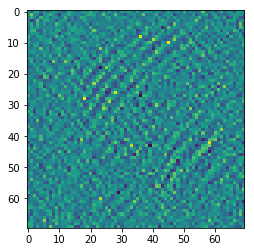

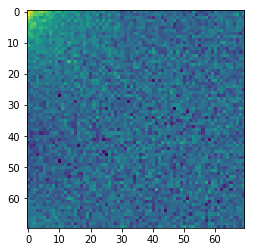

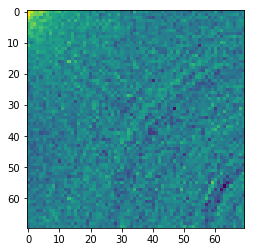

In [82]:
for x in [x1, x3, x2]:
    plt.imshow(x);
    plt.show()

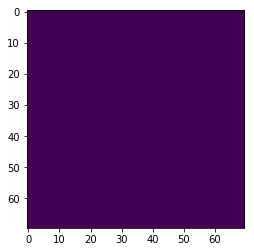

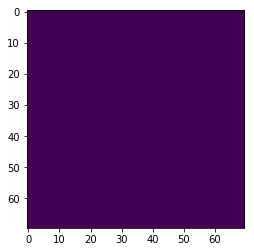

In [83]:
#plt.imshow((x1<1) &(x2<1))
plt.imshow(x1 < .42)
plt.show()
plt.imshow(x3 < .38)

In [34]:
x2.max()

-0.1130375375823619

1. Introduction
2. Lit review
3. Methods & results
    - Capture porosity data from interferometry
        - how to characterize pores ...
            - value: standard, objective way of measuring pores
                - we assume the data is perfect
            - compare high-res with very-high-res and
                - prove that high-res is good enought by getting false negative/positive
            - more concise in metrics
        - Presentation of results
4. Validation
    - is interferometry good enough:
        - assume high-res is the ground truth
    - validate low-res against high-res
        - measures of performance:
            - false negative/positive
        - if good results:
            - describe how
5. Prediction
    - else: (-> Predictig porosity section)
        - predict high-res from low_res
            - describe the method
            - metrics of performance
6. Discussion and conclusions                

In [66]:
model.save('files/model20200226_3.keras')

In [108]:
trainX.shape

(103, 85, 85, 1)

In [140]:
for i in image_generator(trainX):
    print(i.shape)
    break

(20, 21, 21, 1)


In [143]:
#model.fit_generator(image_generator, steps_per_epoch=1)
help(model.fit_generator)

Help on method fit_generator in module keras.engine.training:

fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0) method of keras.engine.sequential.Sequential instance
    Trains the model on data generated batch-by-batch by a Python generator
    (or an instance of `Sequence`).
    
    The generator is run in parallel to the model, for efficiency.
    For instance, this allows you to do real-time data augmentation
    on images on CPU in parallel to training your model on GPU.
    
    The use of `keras.utils.Sequence` guarantees the ordering
    and guarantees the single use of every input per epoch when
    using `use_multiprocessing=True`.
    
    # Arguments
        generator: A generator or an instance of `Sequence`
            (`keras.utils.Sequence`) object in order to avoid
            duplica

In [44]:
a = low_transformed[10]

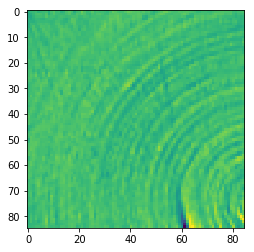

In [43]:
plt.imshow(a)

array([[1.68048837, 1.69744682, 1.70497207, ..., 1.7183922 , 1.72070005,
        1.72741703],
       [1.66447563, 1.67530031, 1.69993033, ..., 1.71020536, 1.70344804,
        1.7084699 ],
       [1.66598409, 1.65760279, 1.69250247, ..., 1.69635368, 1.68675022,
        1.69320385],
       ...,
       [1.69075029, 1.72525898, 1.69599459, ..., 1.6637609 , 1.70188104,
        1.83706774],
       [1.68890297, 1.69692574, 1.69705049, ..., 1.66456865, 1.6750865 ,
        1.73585904],
       [1.69882179, 1.69908653, 1.70401675, ..., 1.63068751, 1.67900845,
        1.70269457]])

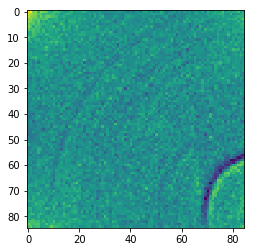

In [60]:
plt.imshow((low_transformed + .8*high_transformed)[92, :, :, 0])

(array([  28.,  138.,  595., 1374., 1850., 1549.,  670.,  161.,   31.,
           4.]),
 array([-1.80675781, -1.39232816, -0.9778985 , -0.56346885, -0.1490392 ,
         0.26539046,  0.67982011,  1.09424976,  1.50867941,  1.92310907,
         2.33753872]),
 <a list of 10 Patch objects>)

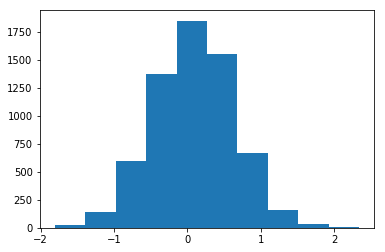

In [82]:
plt.hist(x1.reshape(-1))

(array([1.000e+00, 1.000e+00, 2.000e+00, 3.400e+01, 2.840e+02, 1.584e+03,
        3.507e+03, 9.390e+02, 4.100e+01, 7.000e+00]),
 array([-8.44503615, -7.10616375, -5.76729136, -4.42841896, -3.08954656,
        -1.75067416, -0.41180177,  0.92707063,  2.26594303,  3.60481542,
         4.94368782]),
 <a list of 10 Patch objects>)

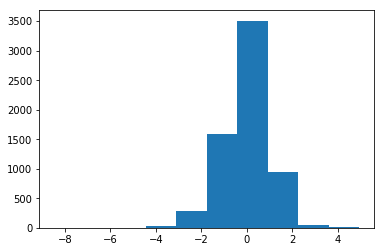

In [95]:
plt.hist(normalize(np.log(x2.reshape(-1)+3)))

(array([2.000e+00, 4.000e+00, 4.000e+00, 2.600e+01, 2.850e+02, 1.812e+03,
        3.479e+03, 7.420e+02, 3.800e+01, 8.000e+00]),
 array([-8.2181929 , -6.8891336 , -5.5600743 , -4.23101501, -2.90195571,
        -1.57289642, -0.24383712,  1.08522217,  2.41428147,  3.74334077,
         5.07240006]),
 <a list of 10 Patch objects>)

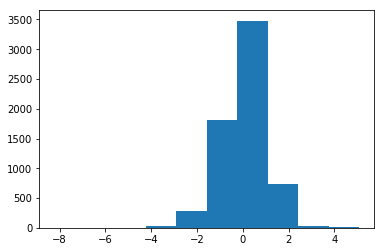

In [94]:
plt.hist(normalize(np.log(x3.reshape(-1)+4)))

(array([3.600e+01, 1.262e+03, 3.757e+03, 1.217e+03, 9.800e+01, 1.500e+01,
        7.000e+00, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([-3.53555595, -2.12766464, -0.71977333,  0.68811798,  2.09600929,
         3.50390061,  4.91179192,  6.31968323,  7.72757454,  9.13546585,
        10.54335716]),
 <a list of 10 Patch objects>)

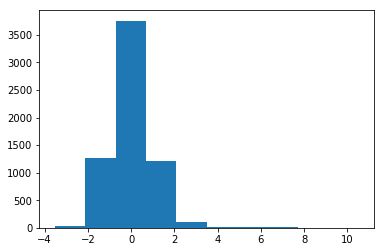

In [96]:
plt.hist(x3.reshape(-1))

In [35]:
x1.max()

2.8260849

In [39]:
x3.min()

-3.6649974127336997